<a href="https://colab.research.google.com/github/GURU0007/Analyse-User-Behaviour-Optimise-User-Workflow/blob/master/fork_of_plant_seedling_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from keras.models import Sequential
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
import tensorflow as tf
import keras
from keras.applications.mobilenet import MobileNet, preprocess_input
from tqdm.notebook import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

## Defining Class

In [4]:
CLASS = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

INV_CLASS = {CLASS[j]:j for j in CLASS}

In [5]:
def preprop_img(image_path, verbose=0):
    if verbose:
        print(image_path)
    img=cv2.imread(image_path)
    img=cv2.resize(img, (128,128))
    return img

## EDA, Visualization and Data preparation

In [7]:
#Reading the image file and converting them to array
train_image=[]
train_label=[]
BASE='/content/drive/MyDrive/SeedlingDataset/train'
for i in tqdm(os.listdir(BASE), total=len(CLASS)):
    for j in os.listdir(os.path.join(BASE,i)):
        train_image.append(preprop_img(os.path.join(BASE,i,j)))
        train_label.append(CLASS[i])
train_image=np.array(train_image)
train_label=np.array(train_label)

print("Shape of train_image:",train_image.shape)


Shape of train_image: (4750, 128, 128, 3)


In [8]:
from keras.utils import np_utils
train_label_cat = np_utils.to_categorical(train_label,len(CLASS))
print(train_label_cat.shape)

(4750, 12)


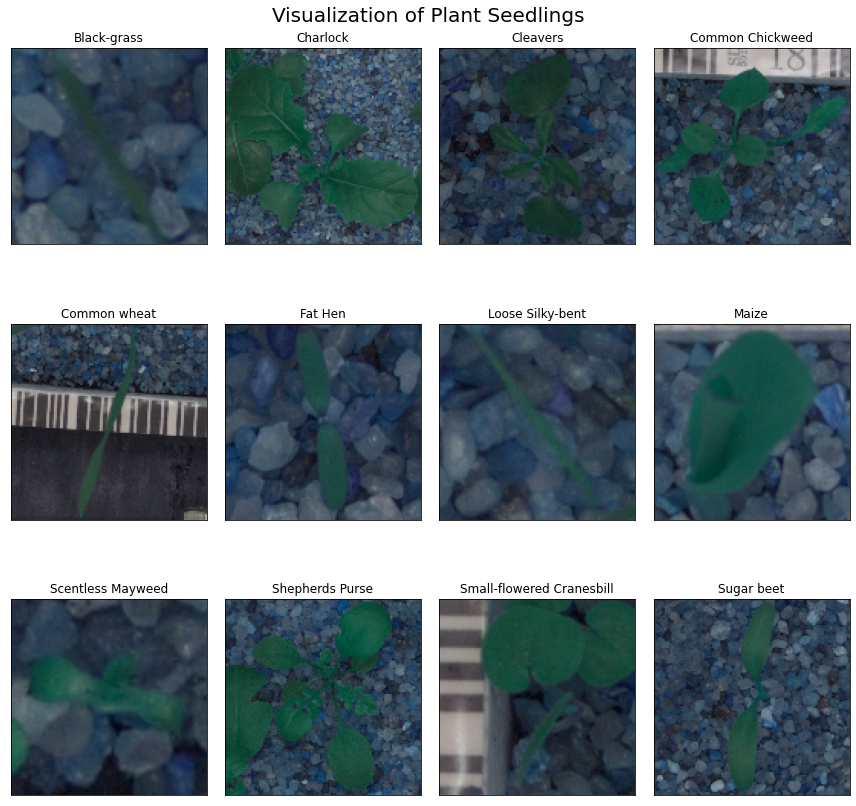

In [9]:
plt.figure(figsize=(12,12))

for i in range(12):  
    
    plt.subplot(3,4,i+1)
    
    index = np.where(train_label==i)[0][1]
    plt.imshow(train_image[index])
    plt.title(INV_CLASS[np.argmax(train_label_cat[index])])
    plt.xticks([]), plt.yticks([])

plt.suptitle("Visualization of Plant Seedlings", fontsize=20)    
plt.tight_layout()
plt.show()

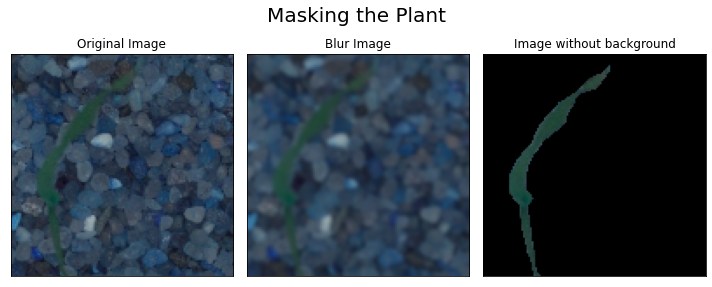

In [12]:
clearTrainImg = []
examples = []; getEx = True
plt.figure(figsize=(10,9))

for img in train_image:
    
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    bMask = mask > 0  
    clear = np.zeros_like(img, np.uint8) 
    clear[bMask] = img[bMask] 
    clearTrainImg.append(clear)
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.xticks([]), plt.yticks([]), plt.title("Original Image")
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.xticks([]), plt.yticks([]), plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(clear)  # Image without background
        plt.xticks([]), plt.yticks([]), plt.title("Image without background")
        getEx = False

plt.suptitle("Masking the Plant", fontsize=20)
plt.tight_layout()

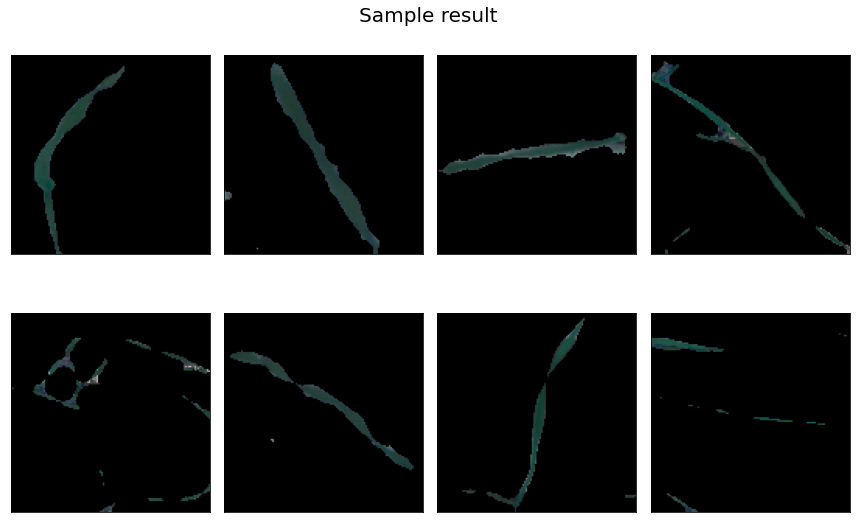

In [13]:
# Visulaising the sample result
clearTrainImg = np.asarray(clearTrainImg)
plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])
    plt.xticks([]), plt.yticks([])
    
plt.suptitle("Sample result", fontsize=20)  
plt.tight_layout()
plt.show()

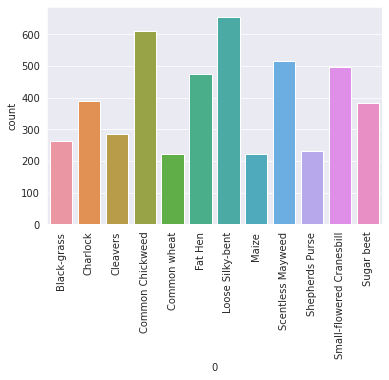

In [14]:
# Plot of label types numbers
classes = list(INV_CLASS.values())

sns.set_style('darkgrid')  
ax = sns.countplot(x=0, data=pd.DataFrame(train_label))
ax.set_xticklabels(classes)

plt.xticks(rotation=90)
plt.show()

In [17]:
clearTrainImg = clearTrainImg / 255

## Splitting the data
* Splitting the image data into train and test class

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(clearTrainImg,train_label_cat, shuffle=True, test_size=0.2)


In [20]:
X_train=X_train.astype('float32') 
X_test=X_test.astype('float32')

In [21]:
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(X_train)

In [22]:
tf.keras.backend.clear_session() #clear the weights

np.random.seed(2)  # Fix seed

model = Sequential([Conv2D(filters=64, kernel_size=(5, 5), input_shape=(128, 128, 3), activation='relu'),
                    BatchNormalization(axis=3),
                    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
                    MaxPooling2D((2, 2)),
                    BatchNormalization(axis=3),
                    Dropout(0.1),
                    
                    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
                    BatchNormalization(axis=3),
                    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
                    MaxPooling2D((2, 2)),
                    BatchNormalization(axis=3),
                    Dropout(0.1),
                   
                    Conv2D(filters=256, kernel_size=(5, 5), activation='relu'),
                    BatchNormalization(axis=3),
                    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
                    MaxPooling2D((2, 2)),
                    BatchNormalization(axis=3),
                    Dropout(0.1),
                   
                    Flatten(),
                    
                    Dense(256, activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                   
                    Dense(256, activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                   
                    Dense(12, activation='softmax')])



model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       2

In [23]:
load_model("/content/drive/MyDrive/SeedlingDataset/model1.h5")

## Callback

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),epochs=25,
                    steps_per_epoch=int(X_train.shape[0]/32),
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    callbacks=[learning_rate_reduction])

Epoch 1/25
118/118 [==============================] - 17s 147ms/step - loss: 2.0244 - accuracy: 0.3803 - val_loss: 3.7324 - val_accuracy: 0.3600
Epoch 2/25
118/118 [==============================] - 17s 145ms/step - loss: 1.6609 - accuracy: 0.4562 - val_loss: 1.4344 - val_accuracy: 0.5337
Epoch 3/25
118/118 [==============================] - 17s 146ms/step - loss: 1.4102 - accuracy: 0.5252 - val_loss: 1.2846 - val_accuracy: 0.5484
Epoch 4/25
118/118 [==============================] - 17s 145ms/step - loss: 1.2439 - accuracy: 0.5839 - val_loss: 2.9442 - val_accuracy: 0.3821
Epoch 5/25
118/118 [==============================] - 17s 145ms/step - loss: 1.1121 - accuracy: 0.6346 - val_loss: 2.3999 - val_accuracy: 0.4179
Epoch 6/25
118/118 [==============================] - 17s 145ms/step - loss: 1.0171 - accuracy: 0.6632 - val_loss: 1.3077 - val_accuracy: 0.6200
Epoch 7/25
118/118 [==============================] - 17s 145ms/step - loss: 0.9371 - accuracy: 0.6829 - val_loss: 0.8586 - val_ac

In [ ]:
model.save("model1.h5")

## Preparing Test Data

In [24]:
from random import shuffle
path = '/content/drive/MyDrive/SeedlingDataset/test/*.png'
files = glob(path)
shuffle(files)

testImg = []

for img in files:
    testImg.append(cv2.resize(cv2.imread(img), (128, 128)))

testImg = np.asarray(testImg)  # Train images set


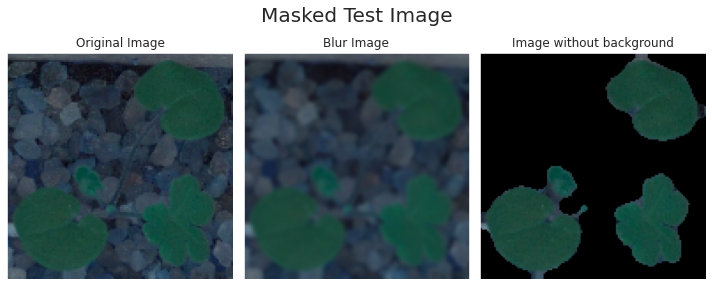

In [25]:
clearTestImg = []
examples = []; getEx = True
plt.figure(figsize=(10,9))

for img in testImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTestImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.xticks([]), plt.yticks([]), plt.title("Original Image")
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.xticks([]), plt.yticks([]), plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(clear)  # Image without background
        plt.xticks([]), plt.yticks([]), plt.title("Image without background")
        getEx = False

plt.suptitle("Masked Test Image", fontsize=20)
plt.tight_layout()
clearTestImg = np.asarray(clearTestImg)

In [26]:

clearTestImg = clearTestImg / 255

## Predictions

In [27]:
pred = model.predict(clearTestImg)
predNum = np.argmax(pred, axis=1)

In [28]:
testId = []
for i in files:
    testId.append(i.split('/')[-1]) 

In [29]:
predStr=[]
for i in predNum:
    predStr.append(INV_CLASS[i])

## Visualising Prediction

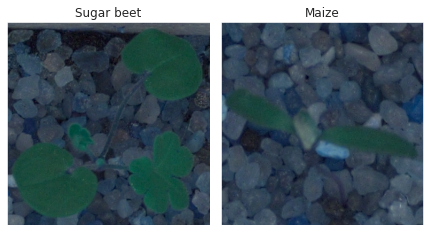

In [30]:
import random
plt.figure(figsize=(12,12))

for i,j in enumerate(files[:2]):  
    
    plt.subplot(3,4,i+1)
    
    img = np.array(cv2.imread(j))
    plt.imshow(img)
    plt.title(predStr[i])
    plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()